### Inlezen flow data

In [1]:
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import figure

import glob

from datetime import datetime
from datetime import datetime, timedelta

import statsmodels.api as sm

from IPython.display import display, Markdown

from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\20175848\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def read_file_to_df(path):
    all_files = glob.glob(path + '/*.csv')
    df = pd.DataFrame()
    for filename in all_files:
        temp = pd.read_csv(filename)
        df = pd.concat([df, temp])
    return df

In [3]:
def fix_data(data, name_of_pump):
    data = data[['datumBeginMeting', 'datumEindeMeting', 'hstWaarde']]
    data = data.rename(columns = {'hstWaarde' : '{}'.format(name_of_pump)})
    data['datetime'] = pd.to_datetime(data['datumBeginMeting'], format = '%Y-%m-%d %H:%M:%S')
    data['datumBeginMeting'] = pd.to_datetime(data['datumBeginMeting'], format='%Y-%m-%d %H:%M:%S')
    data['datumEindeMeting'] = pd.to_datetime(data['datumEindeMeting'], format='%Y-%m-%d %H:%M:%S')
    data = data.set_index('datumBeginMeting')
    data = data.sort_index() # Datetime index
    return data

In [4]:
def first_non_zero(data, name):
    s = pd.Series(data[name])
    f = pd.DataFrame(s.iloc[s.nonzero()[0]]).reset_index()

    m_index = f['datumBeginMeting'][0]
    print(m_index)
    data3 = data.loc[m_index:,:]
    data3[name].plot()
    return data3

In [5]:
def only_changed_rows(df, give_index=False, silent=False):
    changed_elements_index = df.shift() != df
    
    if not silent: # Print amount of changed rows message:
        total = df.shape[0]
        remaining = changed_elements_index.any(axis=1).sum()
        display(Markdown(f"Of **{total:,}** rows, **{total-remaining:,} ({(total-remaining)/total:.2%})**\
        were found to be consecutive duplicates. \n**{remaining:,}** rows remaining."))
    
    return changed_elements_index if give_index else df.loc[changed_elements_index.any(axis=1)]

In [6]:
def timeGrouper(data, name):
    return data.groupby(pd.TimeGrouper('H'))[name].mean()

def timeGrouper2(data, name):
    return data.groupby(pd.TimeGrouper('H'))[name].std()

In [7]:
def main(path, name_of_pump):
    data = read_file_to_df(path)
    data = fix_data(data, name_of_pump)
    data = first_non_zero(data, name_of_pump)
    data = only_changed_rows(data)
    grouped_data = timeGrouper(data, name_of_pump)
    grouped_data2 = timeGrouper2(data, name_of_pump)
    return data, grouped_data, grouped_data2


2018-01-01 00:00:00


Of **863,880** rows, **40 (0.00%)**        were found to be consecutive duplicates. 
**863,840** rows remaining.

C:\Users\20175848\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  
C:\Users\20175848\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  """


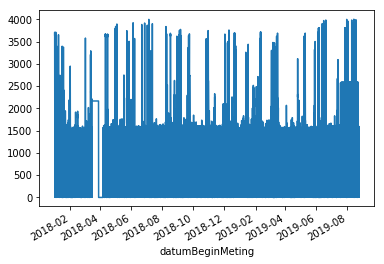

In [8]:
data, grouped, grouped_data2 = main('./data/den bosch/sewer_data_db/flow/Haarsteeg/', 'haarsteeg')

In [9]:
df = pd.DataFrame(grouped)
df['-std'] = df.haarsteeg - grouped_data2
df['+std'] = df.haarsteeg + grouped_data2
grouped_data2.mean()

556.0897843899727

### Inlezen rain data


In [10]:
haarsteeg_rain = pd.read_hdf('regenhaarsteeg.h5', key = 'df')
haarsteeg_rain = pd.DataFrame(haarsteeg_rain)
haarsteeg_rain = haarsteeg_rain.reset_index()
haarsteeg_rain.rename(columns={'Begin':'datumBeginMeting'}, inplace=True)
haarsteeg_rain = haarsteeg_rain.set_index('datumBeginMeting')

### Inlezen level data

In [11]:
haarsteeg_level = pd.read_hdf('level_haarsteeg.h5', key = 'df')
haarsteeg_level = pd.DataFrame(haarsteeg_level.level.dropna())
# haarsteeg_level

### Plotten Raw data


In [12]:
# %matplotlib qt

# fig, axes = plt.subplots(nrows=3,
#                          ncols=1,
#                          sharex=True,figsize=(25,12))

# data.haarsteeg.plot(ax=axes[0], linewidth=2, color='tomato', linestyle='solid',title='Flow',marker='o', markersize=2)


# haarsteeg_rain.reindex(data.index).dropna().plot(ax=axes[1], linewidth=2, color='blue', markerfacecolor='None', linestyle='solid', marker='o', title='Rain')

# haarsteeg_level.level.plot(ax=axes[2], linewidth=2, color='green', markerfacecolor='None', linestyle='solid', marker='o', title='Level')

# plt.show()

### Plotten aggregated data

In [13]:
time_range = pd.date_range(grouped.index.min(), grouped.index.max(), freq='D')
time_range = list(time_range)

In [14]:
%matplotlib qt

fig, axes = plt.subplots(nrows=2,
                         ncols=1,
                         sharex=False,figsize=(25,12))


df.haarsteeg.plot(ax=axes[0], linewidth=2, color='coral', markerfacecolor='None', linestyle='solid', marker='o', title='Average Flow')
df['-std'].plot(ax=axes[0], linewidth=2, color='black', markerfacecolor='None', linestyle='--', title='-std', alpha = 0.5)
df['+std'].plot(ax=axes[0], linewidth=2, color='black', markerfacecolor='None', linestyle='--', title='Average flow plus standard deviations', alpha = 0.5)


for xc in time_range:
    axes[0].axvline(x=xc, color='black', linestyle='--', alpha = 0.25)
    
haarsteeg_rain.reindex(data.index).dropna().plot(ax=axes[1], linewidth=2, color='blue', markerfacecolor='None', linestyle='solid', marker='o', title='Rain')


plt.show()